# Data Preprocessing and Descriptive Analytics of KKBox Dataset

*** Our goal is to accurately predict customer churn***

[WSDM KKBox's Churn Prediction Challenge](https://www.kaggle.com/c/kkbox-churn-prediction-challenge)

## The Business Problem

KKBox is the leader in music streaming in Asia and their business model is based on paid user accounts and advertising revenue with the former being a significant contributor. The client (KKBox) wants a predictive model of customer churn built.

Stage 1 requires descriptive analytics. We will present assumptions about the data & the intended model as we preprocess and explore...

In [1]:
# Importing pandas et al is a given for data scientists working with flat files

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')
import re

In [2]:
# As the name implies, this csv holds subscriber information

members = pd.read_csv('members.csv')
members.head()

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,URiXrfYPzHAlk+7+n7BOMl9G+T7g8JmrSnT/BU8GmEo=,1,0,NaN,9,20150525,20150526
1,U1q0qCqK/lDMTD2kN8G9OXMtfuvLCey20OAIPOvXXGQ=,1,0,NaN,4,20161221,20161224
2,W6M2H2kAoN9ahfDYKo3J6tmsJRAeuFc9wl1cau5VL1Q=,1,0,NaN,4,20160306,20160309
3,1qE5+cN7CUyC+KFH6gBZzMWmM1QpIVW6A43BEm98I/w=,5,17,female,4,20161031,20161107
4,SeAnaZPI+tFdAt+r3lZt/B8PgTp7bcG/1os39u4pLxs=,1,0,NaN,4,20170202,20170205


In [3]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116194 entries, 0 to 5116193
Data columns (total 7 columns):
msno                      object
city                      int64
bd                        int64
gender                    object
registered_via            int64
registration_init_time    int64
expiration_date           int64
dtypes: int64(5), object(2)
memory usage: 273.2+ MB


In [4]:
# Locating missing values in our dataframe...

members.isnull().any()

msno                      False
city                      False
bd                        False
gender                     True
registered_via            False
registration_init_time    False
expiration_date           False
dtype: bool

In [5]:
members['gender'].describe()

count     1761416
unique          2
top          male
freq       902851
Name: gender, dtype: object

** The missing values would most likely be customers withholding information. We will declare an attribute for missing values. **

In [6]:
members['gender'].describe()

count     1761416
unique          2
top          male
freq       902851
Name: gender, dtype: object

** Creating a graphical representation of our gender data... **

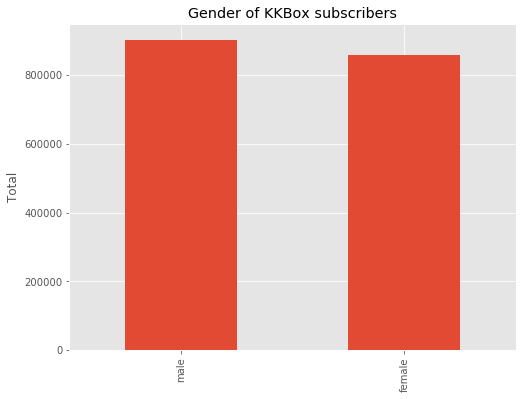

In [7]:
gender = members['gender'].value_counts()
gender.plot(kind='bar',stacked=True, figsize=(8,6))

plt.ylabel('Total')
plt.title("Gender of KKBox subscribers")
plt.show()

In [18]:
members['gender'] = members['gender'].fillna('missing')

In [19]:
members['gender'].describe()

count     5116194
unique          3
top       missing
freq      3354778
Name: gender, dtype: object

In [8]:
# let's find out what unique values our other variables hold...

for column in members:
    print column
    print members[column].unique()

msno
['URiXrfYPzHAlk+7+n7BOMl9G+T7g8JmrSnT/BU8GmEo='
 'U1q0qCqK/lDMTD2kN8G9OXMtfuvLCey20OAIPOvXXGQ='
 'W6M2H2kAoN9ahfDYKo3J6tmsJRAeuFc9wl1cau5VL1Q=' ...,
 'nufMrGILJC0l8UwsEegBJeB4Hr6+WJDuWrfLaipSMDA='
 'dw4PyMqv9x+nWlV+D9JWmMlZExnjnkidxBDmUErGsrA='
 'VJmQvIH9x9SHfo//AMHJaY1MSQw9FVy4Vhjxxk30pCM=']
city
[ 1  5  6 22 13  4 12 15 17 14 11 10  3  9  8 21 18  7 19 20 16]
bd
[    0    17    40    24    56    22    32    19   117    42    25    29
    28    43    41    47    18    20    36    21    50    39    38    26
    27    53    23    16    34    37    48    30    45    52    46    57
    44    33    35    31    58    54    49    55    15    14    79    67
    66    62    51    96    92    61    59    65    81    69    60    63
    64   104   106    97    72    73    84    75   112    94    91    68
   -36    74   102     3    95    12    70   105    76    71   111    80
    78    85  1032    13     2   100     9    90    77     6   103    86
     1     5    87   101   139   -51   107  

**The bd column is a placeholder for subscriber age whose entries range from -6998 to 2015**

*What assumptions can we make about this variable?*

- It is possible this field is stored in a Unix-like database that holds dates as either positive or negative offsets of 1970
- The values could also be user entry errors

As KKBox only accepts registrants from within Asia, we had someone from Hong Kong sign up and we got these screenshots:

<table><tr><td><img src="correct.jpg" style="width: 250px;"></td><td><img src="wrong1.jpg" style="width: 250px;"></td><td><img src="wrong2.jpg" style="width: 250px;"></td></tr></table>

## Clearly, KKbox has data validation issues they need to attend to...

Our observation clearly rules out the Unix case.. 

### We will assume any age lower than 0 and higher than 100 is invalid.

We will assume parents can sign their kids (aged  0 - 10) up for the service.

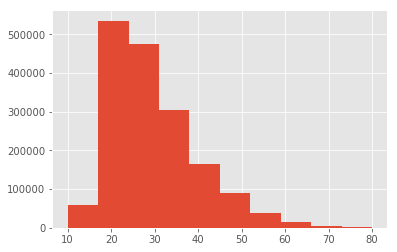

In [20]:
members['bd'].hist()
plt.show()

In [9]:
members.loc[members['bd'] < 10, 'bd'] = np.nan
members.loc[members['bd'] > 80, 'bd'] = np.nan

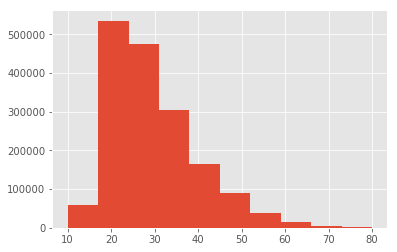

In [10]:
members['bd'].hist()
plt.show()

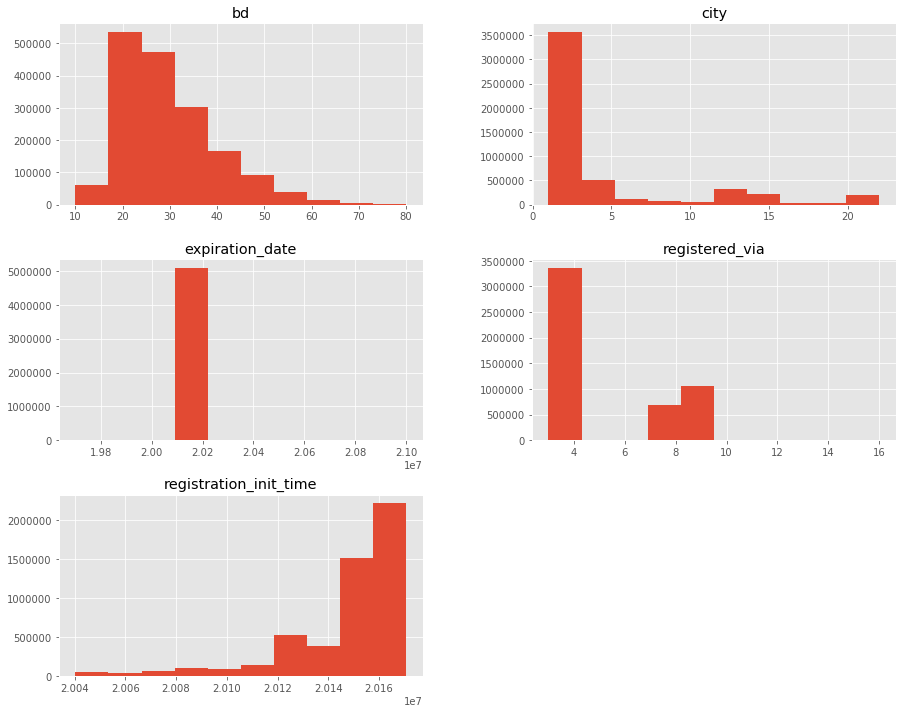

In [11]:
members.hist(figsize=(15,12))
plt.show()

In [12]:
members.columns[members.isnull().any()]

Index([u'bd', u'gender'], dtype='object')

In [21]:
members.columns[members.isnull().any()]

Index([u'bd'], dtype='object')

### Class for Null Values

In [13]:
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):
    
    def __init__(self):
        """Impute missing values.
        
        Columns of dtype object are imputed with the most frequent value in column.
        
        Columns of other types are imputed with median of column.
        
        """
    def fit(self, X, y=None):
        
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
                index=X.columns)
        
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [22]:
# We will transform the variables of time

from datetime import datetime

members['expiration_date'] = members['expiration_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d').date())
members['registration_init_time'] = members['registration_init_time'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d').date())

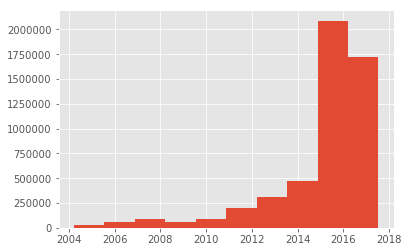

In [22]:
members['registration_init_time'].hist()
plt.show()

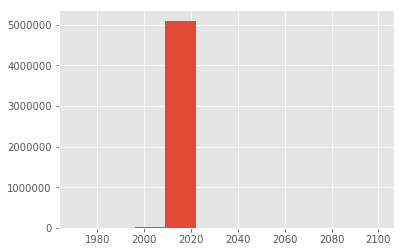

In [23]:
members['expiration_date'].hist()
plt.show()

In [24]:
print members['expiration_date'].max()
members['expiration_date'].min()

2100-01-01


datetime.date(1970, 1, 1)

In [25]:
members['expiration_date'][(members['expiration_date'] < datetime(2004,1,1).date())].count()

676

In [26]:
members.loc[members['expiration_date'] < datetime(2004,1,1).date(), 'expiration_date'] = np.nan
members.loc[members['expiration_date'] > datetime(2050,1,1).date(), 'expiration_date'] = np.nan

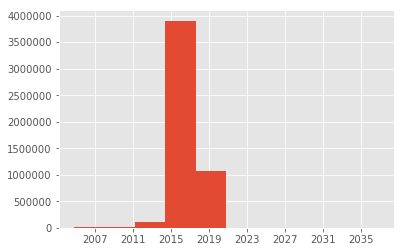

In [27]:
members['expiration_date'].hist()
plt.show()

In [28]:
members['expiration_days'] = members['expiration_date']-datetime(1970,1,1).date()

In [29]:
members['registration_init_days'] = members['registration_init_time']-datetime(1970,1,1).date() 

In [30]:
members = members.drop(['expiration_date','registration_init_time'], axis=1)

In [31]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116194 entries, 0 to 5116193
Data columns (total 7 columns):
msno                      object
city                      int64
bd                        float64
gender                    object
registered_via            int64
expiration_days           timedelta64[ns]
registration_init_days    timedelta64[ns]
dtypes: float64(1), int64(2), object(2), timedelta64[ns](2)
memory usage: 273.2+ MB


In [32]:
members.isnull().any()

msno                      False
city                      False
bd                         True
gender                    False
registered_via            False
expiration_days            True
registration_init_days    False
dtype: bool

In [33]:
members = DataFrameImputer().fit_transform(members)

In [34]:
members.isnull().any()

msno                      False
city                      False
bd                        False
gender                    False
registered_via            False
expiration_days           False
registration_init_days    False
dtype: bool

In [35]:
members.to_csv('members_clean.csv', index=False)

In [36]:
members.head(20)

,msno,city,bd,gender,registered_via,expiration_days,registration_init_days
0,URiXrfYPzHAlk+7+n7BOMl9G+T7g8JmrSnT/BU8GmEo=,1,27.0,missing,9,16581 days,16580 days
1,U1q0qCqK/lDMTD2kN8G9OXMtfuvLCey20OAIPOvXXGQ=,1,27.0,missing,4,17159 days,17156 days
2,W6M2H2kAoN9ahfDYKo3J6tmsJRAeuFc9wl1cau5VL1Q=,1,27.0,missing,4,16869 days,16866 days
3,1qE5+cN7CUyC+KFH6gBZzMWmM1QpIVW6A43BEm98I/w=,5,17.0,female,4,17112 days,17105 days
4,SeAnaZPI+tFdAt+r3lZt/B8PgTp7bcG/1os39u4pLxs=,1,27.0,missing,4,17202 days,17199 days
5,iSJMDbqVrpRf7DRQoCINa6CzxpEIkHj91X5oqpReC3k=,1,27.0,missing,4,16849 days,16846 days
6,NNYKvjuUcXHLi40gmdfpVfdlNOuRxQ1uGYVp45Ce/eY=,1,27.0,missing,9,16636 days,16635 days
7,TA85iK5eP14OHddABVsSlwi4EKTe9sxMBp+9nWsdLq8=,1,40.0,male,3,16601 days,16592 days
8,75rp8sCaeatezkb6c0I133UakcSDuKcc5ia0b0Q+JS4=,1,24.0,male,3,17434 days,16768 days
9,1Nqjt8ykQceNOmuRrh9bcgvicDfLlj+jkgx7+Dd0Rk0=,1,27.0,missing,7,17418 days,16901 days


In [14]:
members['registered_via'] = members['registered_via'].astype('category')
members['city'] = members['city'].astype('category')

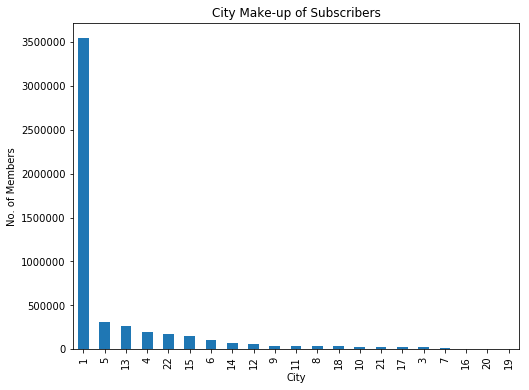

In [41]:
city = members['city'].value_counts()
city.plot(kind='bar',stacked=True, figsize=(8,6))

plt.xlabel('City')
plt.ylabel('No. of Members')
plt.title("City Make-up of Subscribers")
plt.show()

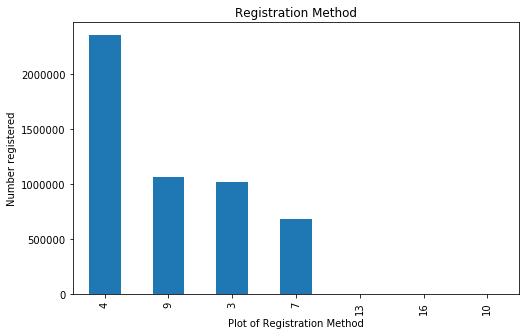

In [43]:
registered_via = members['registered_via'].value_counts()
registered_via.plot(kind='bar',stacked=True, figsize=(8,5))

plt.xlabel('Plot of Registration Method')
plt.ylabel('Number registered')
plt.title("Registration Method")
plt.show()

*** Pending confirmation from a reliable data dictionary, it is safe to assume that city 1 is Taipei, KKBox being a Taiwanese company... ***

In [15]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116194 entries, 0 to 5116193
Data columns (total 7 columns):
msno                      object
city                      category
bd                        int64
gender                    object
registered_via            category
registration_init_time    int64
expiration_date           int64
dtypes: category(2), int64(3), object(2)
memory usage: 204.9+ MB


In [32]:
members['expiration_date'].head()

0    2015-05-26
1    2016-12-24
2    2016-03-09
3    2016-11-07
4    2017-02-05
Name: expiration_date, dtype: object

In [33]:
members['registration_init_time'].describe()

count        5116194
unique          4763
top       2015-10-09
freq           11550
Name: registration_init_time, dtype: object

In [34]:
for column in members:
    print members[column].describe()

count                                          5116194
unique                                         5116194
top       lLEwGD3UEH/O8YCBrUGPRQUUKVi/sCnJULwGIU49Kj4=
freq                                                 1
Name: msno, dtype: object
count     5116194
unique         21
top             1
freq      3541998
Name: city, dtype: int64
count    5.112225e+06
mean     9.665540e+00
std      1.500244e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.100000e+01
max      1.000000e+02
Name: bd, dtype: float64
count     5116194
unique          3
top       missing
freq      3354778
Name: gender, dtype: object
count     5116194
unique          7
top             4
freq      2351944
Name: registered_via, dtype: int64
count        5116194
unique          4763
top       2015-10-09
freq           11550
Name: registration_init_time, dtype: object
count        5116194
unique          5604
top       2017-09-30
freq          137652
Name: expiration_date, dtype: object


In [35]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116194 entries, 0 to 5116193
Data columns (total 7 columns):
msno                      object
city                      category
bd                        float64
gender                    object
registered_via            category
registration_init_time    object
expiration_date           object
dtypes: category(2), float64(1), object(4)
memory usage: 204.9+ MB


** So... We have 7 input variables - 2 categorical (registered via, gender, and city), 4 objects, and age **

In [45]:
members.to_csv("members_trf_data.csv", index=False)

## We will now attempt to describe the transactions data...

In [44]:
import pylab
import seaborn as sns

trans = pd.read_csv("transactions.csv")
trans.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc=,41,30,129,129,1,20150930,20151101,0
1,AZtu6Wl0gPojrEQYB8Q3vBSmE2wnZ3hi1FbK1rQQ0A4=,41,30,149,149,1,20150930,20151031,0
2,UkDFI97Qb6+s2LWcijVVv4rMAsORbVDT2wNXF0aVbns=,41,30,129,129,1,20150930,20160427,0
3,M1C56ijxozNaGD0t2h68PnH2xtx5iO5iR2MVYQB6nBI=,39,30,149,149,1,20150930,20151128,0
4,yvj6zyBUaqdbUQSrKsrZ+xNDVM62knauSZJzakS9OW4=,39,30,149,149,1,20150930,20151121,0


In [46]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547746 entries, 0 to 21547745
Data columns (total 9 columns):
msno                      object
payment_method_id         int64
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             int64
transaction_date          int64
membership_expire_date    int64
is_cancel                 int64
dtypes: int64(8), object(1)
memory usage: 1.4+ GB


** The data has 21,547,745 million rows of data and 9 columns.**

- **msno:** user id
- **payment_method_id:** payment method
- **payment_plan_days:** length of membership plan in days
- **plan_list_price:** in New Taiwan Dollar (NTD)
- **actual_amount_paid:** in New Taiwan Dollar (NTD)
- **is_auto_renew**
- **transaction_date:** format %Y%m%d
- **membership_expire_date:** format %Y%m%d
- **is_cancel:** whether or not the user canceled the membership in this transaction.

**Converting Date Columns - transaction_date and membership_expire_date**

In [48]:
trans['transaction_date'] = trans['transaction_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
trans['membership_expire_date'] = trans['membership_expire_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

KeyboardInterrupt: 

**Testing for NULL values**

In [49]:
trans.isnull().sum()

msno                      0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
dtype: int64

In [50]:
len(trans['msno'].unique())

2363626

In [51]:
#Checking the unique payment method ids

print(trans['payment_method_id'].unique())
print("The number of unique ids used are:", trans['payment_method_id'].nunique())

[41 39 21 37 40 34 33 31 23 38 19 24 14 36 27 35 30 29 28 22 26 32 25 20 17
  5 18 11  7 13 12 16 10 15  8  6  3  2  4  1]
('The number of unique ids used are:', 40)


In [52]:
#Popularity of payment_methods among transactions

paymentmethod = trans.groupby('payment_method_id').size()
paymentmethod.sort_values()

payment_method_id
1           12
4           15
2           52
3          210
6          466
5          474
8          657
7         1094
10        1326
15        1479
11        2129
12        3834
26        4591
13        6571
17        7437
16       11064
14       13621
25       13780
18       16177
24       16196
22       20130
21       22883
20       28278
19       32073
23       42386
27       62525
28       95733
29      113885
32      146481
30      160957
31      252342
33      411164
35      541399
34      731539
36      855115
37     1007689
39     1466655
38     1703590
40     2225283
41    11526454
dtype: int64

**The users are grouped by the number of transactions in the data**

In [53]:
users_by_trans = trans.groupby(['msno']).size()
print("The users with multiple transactions: ",sum(users_by_trans.values > 1))
print("The users with one transaction: ",sum(users_by_trans.values == 1))

('The users with multiple transactions: ', 1771525)
('The users with one transaction: ', 592101)


*** Variable: Payment_plan_days ***

In [54]:
print trans['payment_plan_days'].unique()
print trans['is_cancel'].unique()
print trans['plan_list_price'].unique()
print trans['is_auto_renew'].unique()

[ 30   0  10  31   7 410 195 100 395   1 180 120  60 400  14 360 200  35
  90  21 240 450  70  80  45 110 365  66 270  99   2 230   3  15 425 415
  95]
[0 1]
[ 129  149    0   99  100  119  150 1788  180  894   50  120  500 1599  536
  799  480  477  596 1200  300  930  699  450   35  447  105  298  134 1000
  350  124  400    1  131  126   10 1150   70 1520  265  143 2000  800   15
   30  210  760  600 1825   44]
[1 0]


In [55]:
#Converting to categorical data

trans['payment_method_id'] = trans['payment_method_id'].astype('category')
trans['is_auto_renew'] = trans['is_auto_renew'].astype('category')
trans['is_cancel'] = trans['is_cancel'].astype('category')
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21547746 entries, 0 to 21547745
Data columns (total 9 columns):
msno                      object
payment_method_id         category
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             category
transaction_date          datetime64[ns]
membership_expire_date    int64
is_cancel                 category
dtypes: category(3), datetime64[ns](1), int64(4), object(1)
memory usage: 1.0+ GB


## Data Exploration and Visualisation

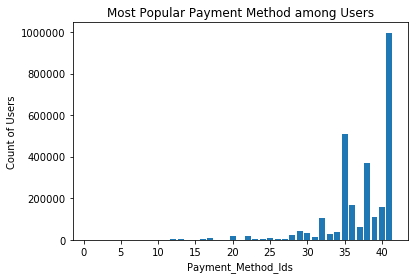

In [56]:
#Popularity of Payment method among users
#This shows us the payment method used by most users within the transactions dataset
paymentmethod = trans.groupby('payment_method_id')['msno'].nunique()
x = paymentmethod.keys()
y = paymentmethod
plt.bar(x,y,0.8)
#plt.ylim([0,12000000])
plt.title('Most Popular Payment Method among Users')
plt.xlabel('Payment_Method_Ids')
plt.ylabel('Count of Users')
plt.show()

##### INSIGHTS: <br>The most popular method of payment among users is 'payment_method_id' = 41

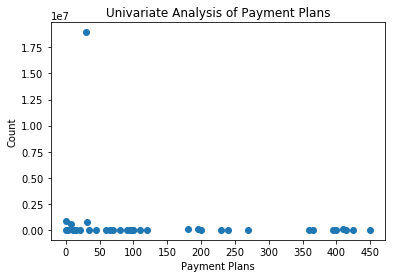

In [57]:
#Univariate Analysis of Membership Plan
paymentplan = trans.groupby('payment_plan_days').size()
x = paymentplan.keys()
y = paymentplan
plt.scatter(x,y)
plt.xticks(np.arange(0, 500, 50))
plt.title('Univariate Analysis of Payment Plans')
plt.xlabel('Payment Plans')
plt.ylabel('Count')
plt.show()

##### INSIGHTS: <br>Most transactions have been performed for Payment Plan of 30 days.<br>                                                                                                                                          There are transactions with Payment Plan of 0 days. This data needs to be analysed further.<br>                                                                                                The largest plan is for about 450 days i.e for 15 months

In [58]:
#Number of Transactions on Auto_Renewal

auto_renewal = trans.groupby('is_auto_renew').size()

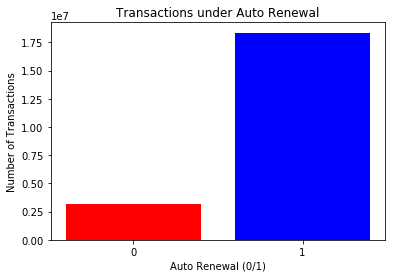

In [59]:
x = (0,1)
y = auto_renewal
plt.bar(x,y,0.8)
plt.xticks([0,1])
plt.title('Transactions under Auto Renewal')
plt.xlabel('Auto Renewal (0/1)')
plt.ylabel('Number of Transactions')
plt.bar(x[0],y[0], color = 'red') #making non auto-renewals => RED
plt.bar(x[1],y[1], color = 'blue') #making auto-renewals => BLUE
plt.show()

##### INSIGHTS:<br> The bulk of transactions are auto-renewals.

In [60]:
#Number of Transaction that are Cancelled
cancelled = trans.groupby('is_cancel').size()

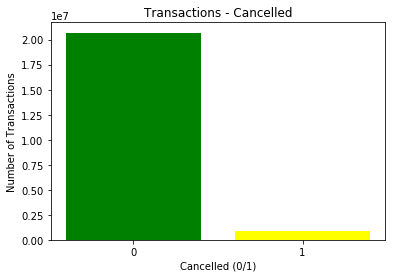

In [61]:
x = cancelled.keys()
y = cancelled
plt.bar(x,y,0.8)
plt.xticks([0,1])
plt.title('Transactions - Cancelled')
plt.xlabel('Cancelled (0/1)')
plt.ylabel('Number of Transactions')
plt.bar(x[0],y[0], color = 'green') #cancellation - no => GREEN
plt.bar(x[1],y[1], color = 'yellow') #cancellation - yes => YELLOW
plt.show()

In [62]:
#Checking for trends across the dates

trans_dates = trans['transaction_date'].value_counts()

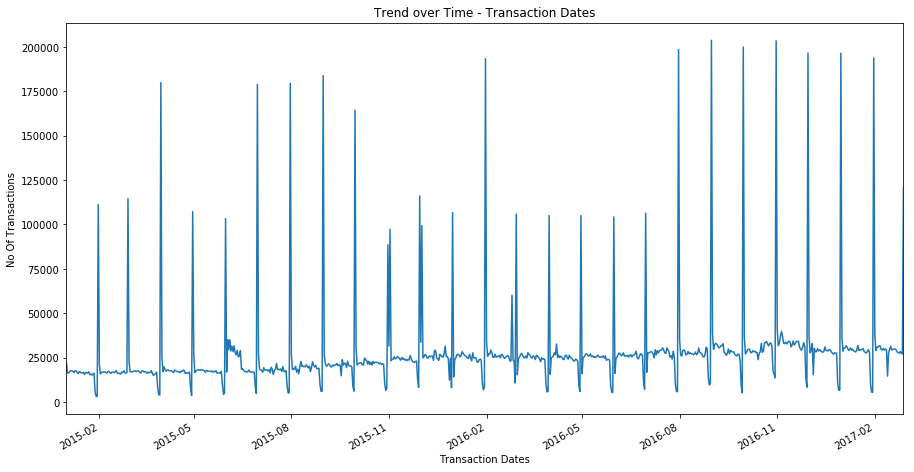

In [63]:
trans_dates.plot(kind ="line",figsize=(15,8))
plt.title("Trend over Time - Transaction Dates")
plt.xlabel("Transaction Dates")
plt.ylabel("No Of Transactions")
plt.show()

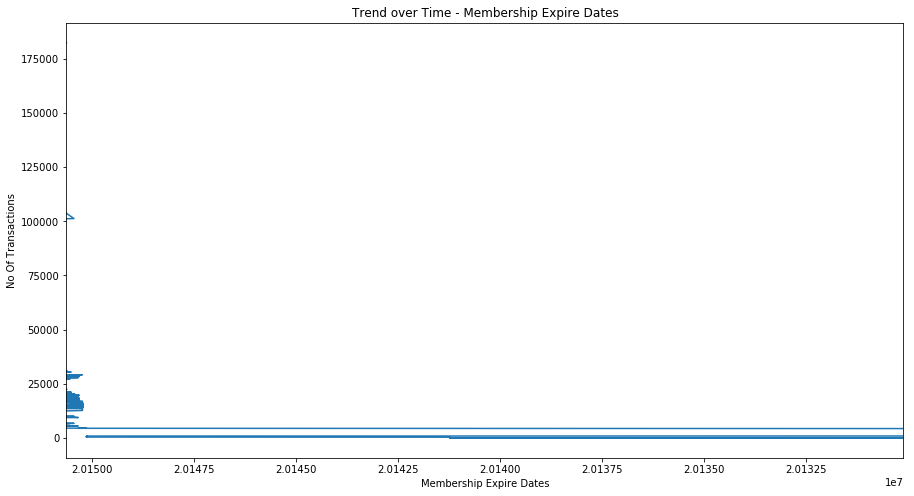

In [64]:
#Looking at Expiration Dates
expire_dates = trans['membership_expire_date'].value_counts()
expire_dates.plot(kind = "line",figsize=(15,8))
plt.title("Trend over Time - Membership Expire Dates")
plt.xlabel("Membership Expire Dates")
plt.ylabel("No Of Transactions")
plt.show()

##### INSIGHTS: From here it is seen that the data starts from 1972, but there is no useful information here.

In [65]:
#Comparing Transaction Dates and Membership Expiration Dates
trans_dates = trans['transaction_date'].value_counts()
expire_dates = trans['membership_expire_date'].value_counts()
expire_dates_n = expire_dates['2015-01-01':'2017-02-28'] #Retaining only dates from 2015-2017
trans_dates.plot(kind ="line",figsize=(15,8))
expire_dates_n.plot(kind = "line",figsize=(15,8))
plt.title("Trend for Transaction Date and Membership Expiration Dates")
plt.xlabel("Dates")
plt.ylabel("No Of Transactions")
plt.show()

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [2015-01-01] of <type 'str'>

In [66]:
#Since this data was mess to read, we drilled down further by months
#Counting the number of transactions by month

trans.index = trans['transaction_date']
trans_month = trans.resample('M').count()

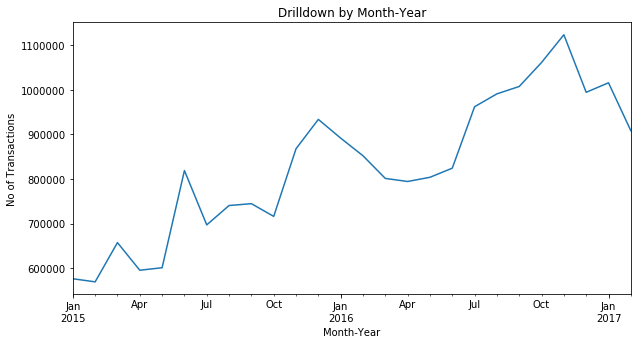

In [67]:
trans_month['msno'].plot(kind = "line",figsize=(10,5))
plt.title("Drilldown by Month-Year")
plt.xlabel("Month-Year")
plt.ylabel("No of Transactions")
plt.show()

In [5]:
members = pd.read_csv("members_trf_data.csv")

In [3]:
train = pd.read_csv("train.csv")

In [4]:
train.head()

,msno,is_churn
0,waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
1,QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
2,fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
3,mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
4,XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 992931 entries, 0 to 992930
Data columns (total 2 columns):
msno        992931 non-null object
is_churn    992931 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.2+ MB


In [7]:
merged_data = members.merge(train, on="msno")

In [18]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 876143 entries, 0 to 876142
Data columns (total 8 columns):
msno                      876143 non-null object
city                      876143 non-null int64
bd                        875623 non-null float64
gender                    876143 non-null object
registered_via            876143 non-null int64
registration_init_time    876143 non-null object
expiration_date           876143 non-null object
is_churn                  876143 non-null category
dtypes: category(1), float64(1), int64(2), object(4)
memory usage: 54.3+ MB


In [8]:
merged_data.head(10)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,is_churn
0,75rp8sCaeatezkb6c0I133UakcSDuKcc5ia0b0Q+JS4=,1,24.0,male,3,2015-11-29,2017-09-25,1
1,1Nqjt8ykQceNOmuRrh9bcgvicDfLlj+jkgx7+Dd0Rk0=,1,0.0,missing,7,2016-04-10,2017-09-09,0
2,gsDjjsDaM2cXEorLK8Qctgf6eO3NU1QgYK5q4j3dhfc=,1,0.0,missing,7,2016-06-08,2017-10-07,0
3,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0.0,missing,7,2011-08-20,2017-09-20,0
4,ZF5OFkIsel+d4VJ4uaOMjThPZRF6XRowQ9ZA/RCvBeY=,1,0.0,missing,7,2016-01-30,2017-10-03,0
5,eMgBkkzRviMP0wvtf/wALwYpyVyfxfCfisRJVAlh+3g=,1,0.0,missing,9,2011-04-02,2017-09-22,0
6,/tdbyriKXZb5TfSyjE4qUl/dppoT+cZtPece2gErPck=,5,0.0,missing,7,2010-12-20,2017-09-27,0
7,jgyrKBspt3xkH/kTo6tkHXcjSZ7Z8W7D7YLonV5Z6Rc=,1,0.0,missing,7,2016-01-17,2017-09-17,0
8,9r83QcYAXqlzqgmx1s4yHHEAbklPdD32JL1Z6UTT0C4=,15,42.0,female,9,2007-08-13,2017-09-20,0
9,k4Zdbf2Sh1ZF1eamTPH72VLDF4QlKLnDJVzutXfkrOA=,1,0.0,missing,7,2016-03-29,2017-10-01,0


In [9]:
merged_data.tail(10)

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date,is_churn
876133,qerkaiyMZF7AbECbeFGn8MC+sI2jL9RKPxMiB1a+8i4=,1,0.0,missing,7,2012-01-10,2017-10-02,0
876134,F425udhQ9cUbevDfBPiXvZ15jup1zd/dtUppcCcxlR0=,1,0.0,missing,7,2012-01-17,2017-09-24,0
876135,CMJ4ETek1UtTBVgnemgECkCSwIex1Y2//TDyMAxkWf8=,4,34.0,female,9,2013-09-20,2017-09-30,0
876136,ezKU31rCHfU1zwF8fszflH9o+Jqt/FvprbNDZVMM1oU=,4,43.0,male,9,2007-05-02,2018-04-28,0
876137,2CNRAUI9AOoNq+52NZ7WLzD40ct+rJvbFvNcQmiaNpM=,22,28.0,male,7,2012-06-09,2017-09-11,0
876138,61vxlJL2MZoLTf6f965Ka681UOQpdNFrMZb8bISHxbE=,1,0.0,missing,3,2014-02-08,2017-08-30,0
876139,PdkHqOPuvE5+qy3gXU+9enRtlf1Lzsqp530N6j64/Xo=,1,0.0,missing,7,2011-12-23,2017-09-10,0
876140,ZxGaoCP7m8QfeW+72Ohvp6ZMKFmNtLb1ct0waBiDDig=,13,32.0,female,9,2010-07-31,2017-09-26,0
876141,F10Hn+qIV08k7nd7i2jdGEEduTMJQjIAgF03dI5t65k=,1,0.0,missing,7,2016-11-29,2017-09-30,0
876142,VJmQvIH9x9SHfo//AMHJaY1MSQw9FVy4Vhjxxk30pCM=,1,0.0,missing,7,2011-03-05,2017-09-08,0


In [10]:
merged_data["is_churn"].describe()

count    876143.000000
mean          0.065793
std           0.247920
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: is_churn, dtype: float64

In [11]:
merged_data['is_churn'] = merged_data['is_churn'].astype('category')

In [12]:
merged_data["is_churn"].describe()

count     876143
unique         2
top            0
freq      818499
Name: is_churn, dtype: int64

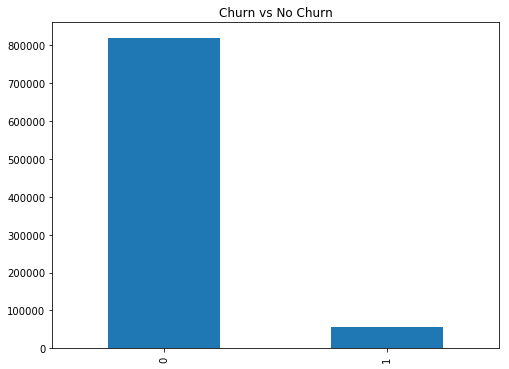

In [13]:
churn = merged_data['is_churn'].value_counts()
churn.plot(kind='bar',stacked=True, figsize=(8,6))

plt.title("Churn vs No Churn")
plt.show()

In [16]:
merged_data.corr()

,city,bd,registered_via
city,1.000000,0.638098,0.017878
bd,0.638098,1.000000,0.083805
registered_via,0.017878,0.083805,1.000000


In [ ]:
churners = merged_data